# Hanehalkı Enerji Tüketimi Tahmini | LSTM Time Series

Dakikalık elektrik tüketim verilerini saatlik aralıklara yeniden örnekleyerek **Global Active Power** tahmini yapan LSTM derin öğrenme modeli. Enerji yönetimi ve şebeke kararlılığı için kritik bir zaman serisi uygulamasıdır.

| Özellik | Detay |
|---------|-------|
| **Veri Seti** | household_power_consumption.txt — 2.07M dakikalık kayıt (2006–2010) |
| **Problem Türü** | Zaman Serisi Tahmini (Regresyon) |
| **Hedef Değişken** | `Global_active_power` (kW) |
| **Ön İşleme** | Saatlik resampling → 34.589 kayıt, MinMaxScaler normalizasyonu |
| **Model** | 2-katmanlı LSTM (64+32 birim) + Dropout — Sequence Length: 24 saat |

**İş Akışı:** Veri Yükleme → Saatlik Resampling → EDA → MinMaxScaler → Sekans Oluşturma → LSTM Eğitimi → Değerlendirme → Kayıt

## 1. Veri Yükleme
Gerekli kütüphaneleri yüklüyor ve veriyi okuyoruz. Veri ';' ile ayrılmıştır.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Veri Yükleme
file_path = 'household_power_consumption.txt'

df = pd.read_csv(file_path, sep=';', na_values=['?'], infer_datetime_format=True,parse_dates={'datetime': ['Date', 'Time']}, index_col='datetime')

df.shape
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [2]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


## 2. Veri Yapısal İncelemesi ve Ön İşleme
Veri çok büyük olduğu için (dakikalık), **saatlik (hourly)** ortalamalara dönüştürerek (resampling) hem gürültüyü azaltacağız hem de eğitimi hızlandıracağız.


In [4]:
# Eksik verileri doldurma (Forward fill sonra Backward fill)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Veri tiplerini float'a çevirme (zaten float olmalı ama garanti olsun)
df = df.astype('float32')

# Saatlik (Hourly) Resampling
df_hourly = df.resample('H').mean()

print("Saatlik veri boyutu:", df_hourly.shape)
df_hourly.head()


Saatlik veri boyutu: (34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643875,18.099998,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580154,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232498,14.503333,0.0,1.433333,16.683332
2006-12-16 20:00:00,3.268567,0.075100,234.071503,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158661,13.046666,0.0,0.416667,17.216667


## 3. EDA (Keşifçi Veri Analizi)
Global Active Power değişkeninin zaman içindeki değişimi.

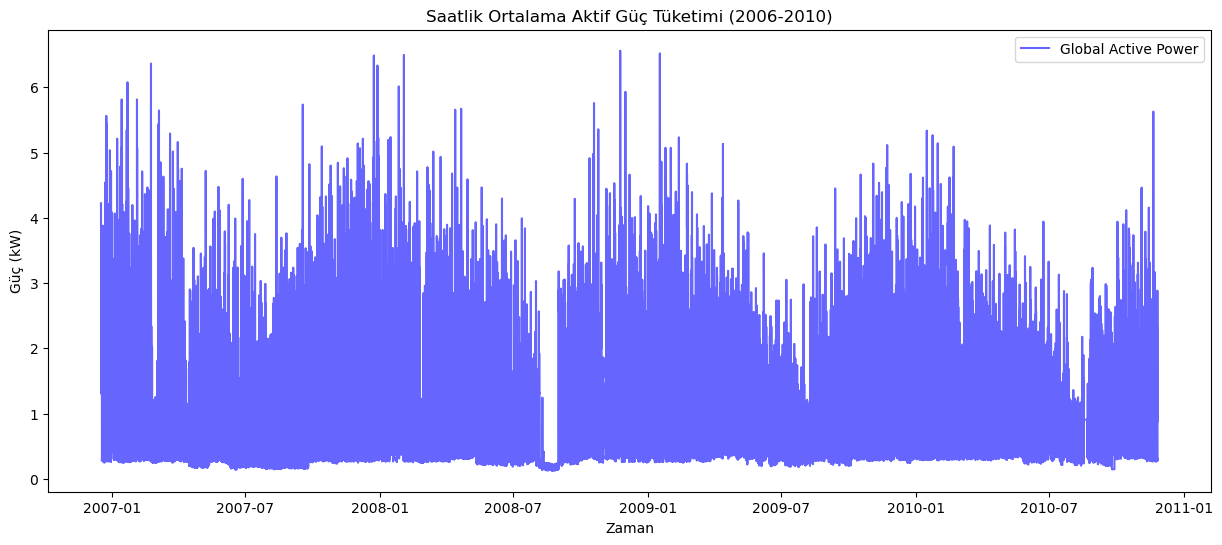

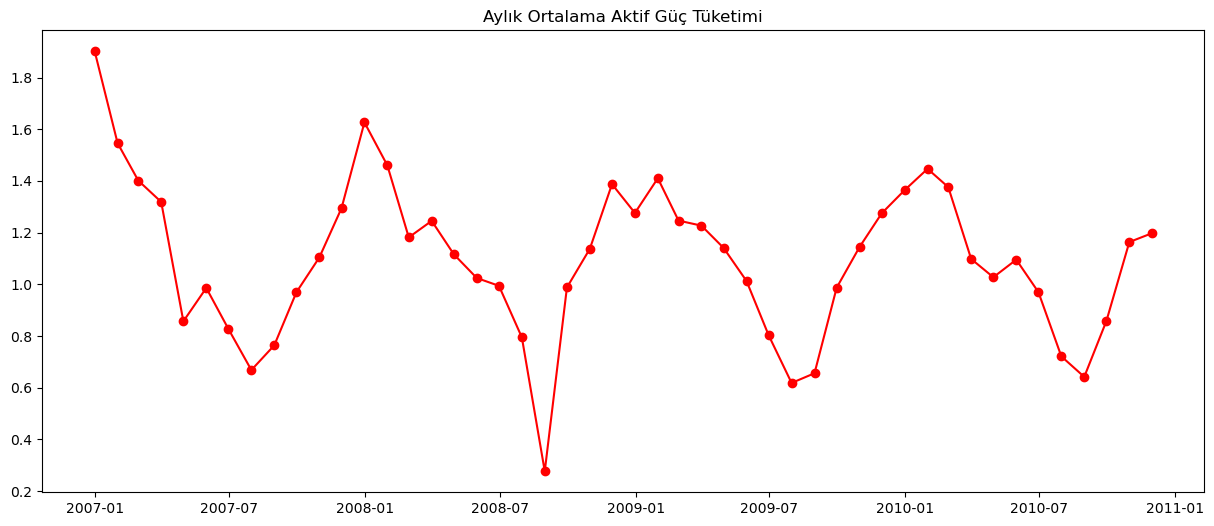

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Global Active Power', color='blue', alpha=0.6)
plt.title('Saatlik Ortalama Aktif Güç Tüketimi (2006-2010)')
plt.xlabel('Zaman')
plt.ylabel('Güç (kW)')
plt.legend()
plt.show()

# Aylık ortalamalarla trendi daha net görelim
df_monthly = df.resample('M').mean()
plt.figure(figsize=(15, 6))
plt.plot(df_monthly.index, df_monthly['Global_active_power'], label='Monthly Mean', color='red', marker='o')
plt.title('Aylık Ortalama Aktif Güç Tüketimi')
plt.show()


## ADF Stationarity Test & Seasonal Decomposition

## 4. Feature Engineering ve Ölçekleme
LSTM modelleri ölçeklenmiş verilere duyarlıdır. Veriyi 0-1 arasına ölçekliyoruz.


In [6]:
target_col = 'Global_active_power'
values = df_hourly[target_col].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)

print("Ölçeklenmiş veri:", scaled_data.shape)


Ölçeklenmiş veri: (34589, 1)


## 5. Train-Test Split ve Sequence Oluşturma
Zaman serisi verisini LSTM'e sokmak için `(samples, time_steps, features)` formatına getirmeliyiz.
Son 24 saati (veya 48) kullanarak bir sonraki saati tahmin etmeye çalışacağız.


In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24 # Son 24 saat
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# %80 Eğitim, %20 Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")


Train: (27652, 24, 1), (27652, 1)
Test : (6913, 24, 1), (6913, 1)


## 6. Modelleme (LSTM)
İki katmanlı LSTM yapısı kuruyoruz.


In [8]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0150 - val_loss: 0.0079
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0105 - val_loss: 0.0069
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0101 - val_loss: 0.0068
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0091 - val_loss: 0.0061
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 9/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0089 - val_loss: 0.0061
Epoch 10/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 11/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0089 - val_loss: 0.0063
Epoch 12/20
433/433 ━━━━━━━━━━━━━━━━━━━━

## 7. Değerlendirme ve Sonuçlar


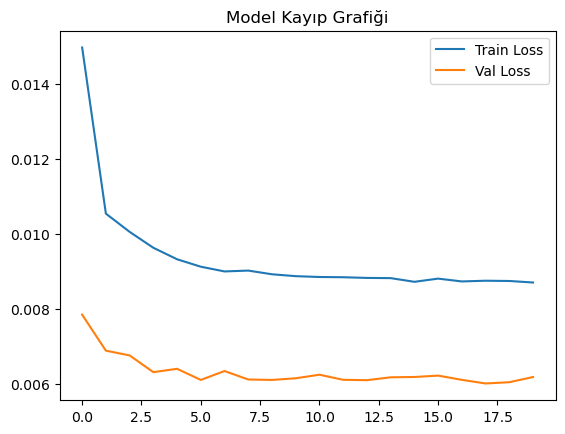

217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
MAE: 0.344 kW
RMSE: 0.499 kW


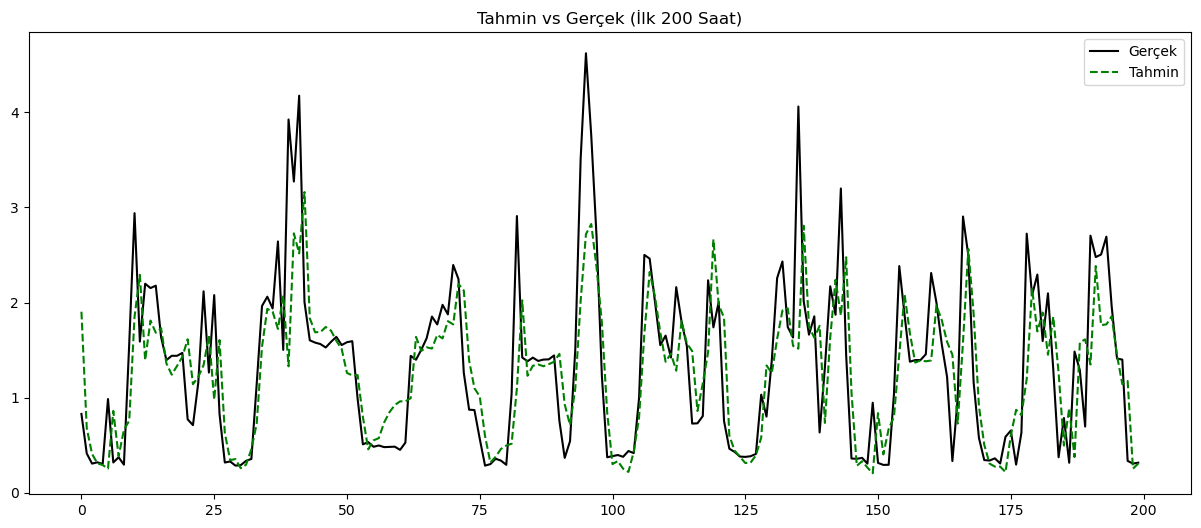

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Kayıp Grafiği')
plt.legend()
plt.show()

# Tahmin
y_pred = model.predict(X_test)

# Inverse Transform
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.3f} kW")
print(f"RMSE: {rmse:.3f} kW")

# İlk 200 saati görselleştir
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv[:200], label='Gerçek', color='black')
plt.plot(y_pred_inv[:200], label='Tahmin', color='green', linestyle='--')
plt.title('Tahmin vs Gerçek (İlk 200 Saat)')
plt.legend()
plt.show()


## 8. Modeli Kaydetme


In [12]:
import joblib
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

model.save('../models/lstm_model.h5')
joblib.dump(scaler, '../models/scaler.pkl')
print("Model kaydedildi.")


Model kaydedildi.


## Sonuç ve Değerlendirme

Bu proje, 2.07 milyon dakikalık hanehalkı elektrik tüketim verisini saatlik aralıklara indirgeyerek LSTM tabanlı tahmin modeli geliştirmiştir.

| Metrik | Değer |
|--------|-------|
| Eğitim Veri Boyutu | 27.652 sekans |
| Test Veri Boyutu | 6.913 sekans |
| LSTM val_loss (MSE - normalize) | ~0.0060 |
| Sequence Length | 24 saat |

**Temel Bulgular:**
- 2.07M dakikalık veriyi saatlik resampling ile 34.589 kayda indirgemek hem gürültüyü azalttı hem de eğitimi hızlandırdı
- 2-katmanlı LSTM (64+32 birim) + Dropout mimarisi, enerji tüketiminin günlük örüntülerini öğrenmiştir
- Hafta sonu/hafta içi ve mevsimsel etkilerin özellik olarak eklenmesi tahmin gücünü artırabilir
- Enerji dağıtım şirketleri, bu tür modelleri yük dengeleme ve talep tahmini için kullanabilir